In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import datetime as datetime
import matplotlib.colors as mcolors
import seaborn as sns

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
import pickle

from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

In [4]:
ds = xr.open_dataset('/home/sachin/Documents/NIPR/Research/Data/AMPERE/processed/ampere_omni_2009_2021_10min.nc')
ds['doy_sin'] = np.sin(2*np.pi*ds['doy']/365)
ds['doy_cos'] = np.cos(2*np.pi*ds['doy']/365)
#ds = ds.sel(dt=slice('2015-03-12', '2015-03-22'))
ds

<xarray.Dataset> Size: 6GB
Dimensions:         (dt: 635616, mlat: 50, mlt: 24)
Coordinates:
  * dt              (dt) datetime64[ns] 5MB 2009-12-01 ... 2021-12-31T23:50:00
  * mlat            (mlat) float64 400B 40.0 41.02 42.04 ... 87.96 88.98 90.0
  * mlt             (mlt) float64 192B 0.0 1.043 2.087 3.13 ... 21.91 22.96 24.0
Data variables:
    jPar            (dt, mlat, mlt) float64 6GB ...
    BX_GSE          (dt) float64 5MB ...
    BY_GSE          (dt) float64 5MB ...
    BZ_GSE          (dt) float64 5MB ...
    flow_speed      (dt) float64 5MB ...
    proton_density  (dt) float64 5MB ...
    F10.7           (dt) float64 5MB ...
    Kp              (dt) float64 5MB ...
    doy             (dt) float64 5MB 335.0 335.0 335.0 ... 365.0 365.0 365.0
    doy_sin         (dt) float64 5MB -0.4938 -0.4938 ... 6.432e-16 6.432e-16
    doy_cos         (dt) float64 5MB 0.8696 0.8696 0.8696 0.8696 ... 1.0 1.0 1.0

In [5]:
def clock_angle(By, Bz):
    angle = np.rad2deg(np.arctan2(By, Bz))
    np.where(angle < 0, angle + 360, angle)
    return angle

def cross_polar_cap_pot(v_sw,By, Bz):
    #Not in SI units
    #from https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/96JA01742
    #and  https://www.sws.bom.gov.au/Category/Solar/Solar%20Conditions/Solar%20Wind%20Clock%20Angle/Solar%20Wind%20Clock%20Angle.php

    theta  = clock_angle(By, Bz)
    B_L = np.sqrt(By**2 + Bz**2)

    CPCP = 10e-4 * v_sw**2 + 11.7 * B_L * (np.sin(np.deg2rad(theta)/2))**3

    return CPCP

def calc_akasofu(v_sw, Bx, By, Bz):
    #https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2002JA009283
    #In SI units
    v_sw = v_sw * 1e3
    Bx = Bx * 10e-9
    By = By * 10e-9
    Bz = Bz * 10e-9
    B = np.sqrt(Bx**2 + By**2 + Bz**2)
    l_0 = 6371 * 7 * 1e3 #7 R_E
    mu_0 = np.pi * 4 * 10e-7
    theta  = clock_angle(By, Bz)
    epsilon_A = (4 * np.pi / mu_0) * v_sw * B**2 * np.sin(theta / 2)**4 * l_0**2
    return epsilon_A 

#ds['epislon_A'] = calc_akasofu(ds['flow_speed'], ds['BX_GSE'], ds['BY_GSE'], ds['BZ_GSE'])
#ds['CPCP'] = cross_polar_cap_pot(ds['flow_speed'],  ds['BY_GSE'], ds['BZ_GSE'])
#ds

In [6]:
def nan_count(ds, var):
    #count number of NaNs in a data variable
    con_data = ds[var].values
    nan_count = np.count_nonzero(np.isnan(con_data))
    nan_ratio = nan_count / con_data.size
    not_nan = con_data.size - nan_count
    return not_nan, nan_count, np.round(nan_ratio, 2)

#nan_count(ds, 'jPar')

In [7]:
# Initialize scalers for the target variable and input variables
input_scaler = StandardScaler()

# Extract the target variable and reshape for scaling
target_var = ds['jPar'].values  # shape (t (n), mlat (50), mlt (24))

# Extract and scale input variables (variables that are dependent only on 'dt')
input_vars = ['BX_GSE', 'BY_GSE', 'BZ_GSE', 'flow_speed', 'proton_density', 'F10.7', 'doy_sin','doy_cos']
input_data = np.array([ds[var].values for var in input_vars]).T  # shape (22320, number_of_vars)
input_data_scaled = input_scaler.fit_transform(input_data)

file_path = f'scaler_id3.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(input_scaler, file)


def no_lookback(target_data, input_data):
    X = input_data[:,np.newaxis,:]
    y = target_data

    return np.array(X), np.array(y)

X, y = no_lookback(target_var, input_data_scaled)
X.shape, y.shape

((635616, 1, 8), (635616, 50, 24))

In [31]:
def simple_time_series_split(X, y, train_ratio=0.9, test_ratio=0.05):

    # Calculate split indices
    train_idx = int(len(X) * train_ratio)
    test_idx = int(len(X) * (train_ratio +test_ratio))

    # Perform the split
    X_train, X_val, X_test = X[:train_idx], X[train_idx:test_idx], X[test_idx:]
    y_train, y_val, y_test = y[:train_idx], y[train_idx:test_idx], y[test_idx:]
    
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = simple_time_series_split(X, y)
X_train.shape, X_val.shape, X_test.shape

((572054, 1, 8), (31781, 1, 8), (31781, 1, 8))

In [32]:
# Convert data to PyTorch tensors and move to GPU
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = np.array(y_test)

# Create DataLoader
batch_size = 128
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

X_train.shape, y_train.shape


(torch.Size([572054, 1, 8]), torch.Size([572054, 50, 24]))

In [33]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True) 
        
        self.fc = nn.Linear(hidden_size, 50*24)

    def forward(self, x):
        batch_size = x.size(0) # Get the batch size
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device) # Initial hidden state
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device) # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0)) 
        out = self.fc(out[:, -1, :]) # Get the last output of the LSTM
        out = out.view(-1, 50, 24) # Reshape to (batch_size, mlat, mlt)
        return out
    
    def reset_states(self):
        # Reset the internal states of the LSTM layer
        self.lstm.reset_parameters()

# Instantiate the model with lookback size
model = LSTM(8, 64, 3)
model.to(device)
model

LSTM(
  (lstm): LSTM(8, 64, num_layers=3, batch_first=True)
  (fc): Linear(in_features=64, out_features=1200, bias=True)
)

In [34]:
loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=8e-5)
scheduler = StepLR(optimizer, step_size=8, gamma=0.7)

In [35]:
def calculate_delta(lat1, lon1, lat2, lon2):
    radius = 6371.008

    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    delta_x = dlat * radius
    delta_y = dlon * radius * np.cos(np.radians(lat1))
    
    return delta_x, delta_y


areas = np.zeros((49, 23))
mlat = np.linspace(40, 90,50) #50 intervals between 40° to 90°
mlt = np.linspace(0,360,24) #24 intervals between 0° to 360°

for i in range(len(mlat) - 1):
    for j in range(len(mlt) - 1):
        lat1, lat2 = mlat[i], mlat[i + 1]
        lon1, lon2 = mlt[j], mlt[j + 1]
        
        delta_x, delta_y = calculate_delta(lat1, lon1, lat2, lon2)
        
        area = delta_x * delta_y
        areas[i, j] = area


In [36]:
from scipy import interpolate

def weighted_loss_function(y_true, y_pred, dampener=0.1):
    weights = np.log2(areas)*2
    weights = weights / np.sum(weights)

    x = np.arange(weights.shape[1])
    y = np.arange(weights.shape[0])
    f = interpolate.interp2d(x, y, weights, kind='linear')
    xnew = np.arange(0, weights.shape[1], weights.shape[1]/(weights.shape[1]+1))
    ynew = np.arange(0, weights.shape[0], weights.shape[0]/(weights.shape[0]+1))
    
    weights = f(xnew, ynew)
   
    #weights = np.flipud(weights)
    weights = np.copy(weights)
    
    loss = torch.mean(torch.abs(y_true - y_pred) * torch.tensor(weights, dtype=torch.float32).to(device))
    loss = loss * 1e3

    return loss

In [38]:
# Train the model
num_epochs = 25
train_losses = []
val_losses = []

# Early stopping
best_val_loss = float('inf')
patience = 5
counter = 0

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for X_batch, y_batch in train_loader:
        # Forward pass
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        train_outputs = model(X_batch)
        #print(train_outputs.shape, y_batch.shape)
        #loss = loss_function(train_outputs, y_batch)
        loss = weighted_loss_function(train_outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Step the scheduler
    scheduler.step()

    train_loss = epoch_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            val_outputs = model(X_batch)
            #val_loss += loss_function(val_outputs, y_batch).item()
            val_loss += weighted_loss_function(val_outputs, y_batch).item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_lstm_model.pt')
    else:
        counter += 1
        if counter == patience:
            print(f'Validation loss did not improve for {patience} epochs. Stopping training.')
            break
        else:
            continue

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss (MAE): {train_loss:.4f}, Val Loss (MAE): {val_loss:.4f}, Best Val Loss: {best_val_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.1e}')

best_model = LSTM(8, 64, 3)
best_model.load_state_dict(torch.load('best_lstm_model.pt'))
best_model.to(device)

/tmp/ipykernel_10666/3623109441.py:9: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(x, y, weights, kind='linear')
/tmp/ipykernel_10666/3623109441.py:13: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolato

Epoch [1/25], Train Loss (MAE): 0.0639, Val Loss (MAE): 0.0556, Best Val Loss: 0.0556, LR: 8.0e-05
Epoch [2/25], Train Loss (MAE): 0.0636, Val Loss (MAE): 0.0546, Best Val Loss: 0.0546, LR: 8.0e-05
Epoch [3/25], Train Loss (MAE): 0.0630, Val Loss (MAE): 0.0538, Best Val Loss: 0.0538, LR: 8.0e-05
Epoch [4/25], Train Loss (MAE): 0.0624, Val Loss (MAE): 0.0535, Best Val Loss: 0.0535, LR: 8.0e-05
Epoch [5/25], Train Loss (MAE): 0.0621, Val Loss (MAE): 0.0533, Best Val Loss: 0.0533, LR: 8.0e-05
Epoch [6/25], Train Loss (MAE): 0.0619, Val Loss (MAE): 0.0532, Best Val Loss: 0.0532, LR: 8.0e-05
Epoch [7/25], Train Loss (MAE): 0.0616, Val Loss (MAE): 0.0529, Best Val Loss: 0.0529, LR: 8.0e-05
Epoch [8/25], Train Loss (MAE): 0.0614, Val Loss (MAE): 0.0528, Best Val Loss: 0.0528, LR: 5.6e-05
Epoch [9/25], Train Loss (MAE): 0.0614, Val Loss (MAE): 0.0528, Best Val Loss: 0.0528, LR: 5.6e-05
Epoch [10/25], Train Loss (MAE): 0.0612, Val Loss (MAE): 0.0527, Best Val Loss: 0.0527, LR: 5.6e-05
Epoch [11

LSTM(
  (lstm): LSTM(8, 64, num_layers=3, batch_first=True)
  (fc): Linear(in_features=64, out_features=1200, bias=True)
)

### Make Predictions

In [39]:
with torch.no_grad():
     predictions = best_model(X_test).cpu().numpy()


### Calulate Global Scores

In [40]:
RMSE = np.sqrt(np.mean((y_test - predictions)**2))
NRMSE = RMSE / np.std(y_test)
MAE = np.mean(np.abs(y_test - predictions))
R = np.corrcoef(y_test.flatten(), predictions.flatten())[0, 1]

def skill(m, o):
    skill = 1 - (np.sum((m - o)**2) / np.sum((o - np.mean(o))**2))
    return skill      

PE = skill(predictions, y_test)

print(f'Test Loss (RMSE): {RMSE:.4f}, Test Loss (NRMSE): {NRMSE:.4f}, Test Loss (MAE): {MAE:.4f}, R: {R:.4f}, Skill: {PE:.4f}')

Test Loss (RMSE): 0.1202, Test Loss (NRMSE): 0.8671, Test Loss (MAE): 0.0664, R: 0.5068, Skill: 0.2482


### Daily Predictions

In [41]:
def open_multiple_nc(nc_files):
    ds = xr.open_mfdataset(nc_files, concat_dim='dt', combine='nested', parallel=True)
    ds['doy_sin'] = np.sin(2*np.pi*ds['doy']/365)
    ds['doy_cos'] = np.cos(2*np.pi*ds['doy']/365)

    #average over 5min
    ds = ds.resample(dt='10min').mean()
    #ds = ds.interpolate_na(dim='dt')

    #ds = ds.sel(nRec=slice(16500, 17000))

    return ds

dir = '/home/sachin/Documents/NIPR/Research/Data/AMPERE/processed/excluded/*.nc'
open_multi_amp = open_multiple_nc(dir)
open_multi_amp

<xarray.Dataset> Size: 1MB
Dimensions:         (mlat: 50, mlt: 24, dt: 144)
Coordinates:
  * mlat            (mlat) float64 400B 40.0 41.02 42.04 ... 87.96 88.98 90.0
  * mlt             (mlt) float64 192B 0.0 1.043 2.087 3.13 ... 21.91 22.96 24.0
  * dt              (dt) datetime64[ns] 1kB 2013-05-14 ... 2013-05-14T23:50:00
Data variables: (12/15)
    jPar            (dt, mlat, mlt) float64 1MB dask.array<chunksize=(1, 50, 24), meta=np.ndarray>
    BX_GSE          (dt) float64 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    BY_GSE          (dt) float64 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    BZ_GSE          (dt) float64 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    flow_speed      (dt) float64 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    proton_density  (dt) float64 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    ...              ...
    ASY_H           (dt) float64 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    F10.7           (dt) float64 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    Kp              (dt) float64 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    doy             (dt) float64 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    doy_sin         (dt) float64 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    doy_cos         (dt) float64 1kB dask.array<chunksize=(1,), meta=np.ndarray>

In [42]:
def split_to_df(ds):
    ds = ds.copy()

    dt = ds['dt'].values.flatten()
    BX_GSE = ds['BX_GSE'].values.flatten() #1
    BY_GSE = ds['BY_GSE'].values.flatten() #2
    BZ_GSE = ds['BZ_GSE'].values.flatten() #3
    flow_speed = ds['flow_speed'].values.flatten() #4
    proton_density = ds['proton_density'].values.flatten() #5
    doy_sin = ds['doy_sin'].values.flatten() #6
    doy_cos = ds['doy_cos'].values.flatten() #7
    
    #AL_INDEX = ds['AL_INDEX'].values.flatten() #6
    #AU_INDEX = ds['AU_INDEX'].values.flatten() #7
    #SYM_H = ds['SYM_H'].values.flatten() #8
    #ASY_H = ds['ASY_H'].values.flatten()  #9
    F10_7 = ds['F10.7'].values.flatten() #10
    #Kp = ds['Kp'].values.flatten() #11
    CPCP = cross_polar_cap_pot(ds['flow_speed'],  ds['BY_GSE'], ds['BZ_GSE'])

    #return BX_GSE.shape

    df_dict = {'dt':dt, 'BX_GSE': BX_GSE, 'BY_GSE': BY_GSE, 'BZ_GSE': BZ_GSE, 'flow_speed': flow_speed, 'proton_density': proton_density,'F10.7': F10_7, 'doy_sin': doy_sin, 'doy_cos': doy_cos}
    df = pd.DataFrame(df_dict)
    
    df_2 = df.copy()
    df_2 = df_2.drop(columns=['dt'])

    return df, df_2

split_to_df(open_multi_amp)
df_raw, df_proc = split_to_df(open_multi_amp)
col_names = df_raw.columns

In [43]:
norm_arr = input_scaler.transform(df_proc)

def create_sequences(arr):
    arr = arr[:,np.newaxis,:]

    return arr
proc_seq = create_sequences(norm_arr)
raw_seq = df_raw.values

/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [44]:
# Assuming best_model is already defined and loaded
device = torch.device('cpu')
best_model.to(device)  # Ensure the model is on the CPU
best_model.eval()

#convert to tensor and put on GPU to match model
norm_proc = torch.tensor(proc_seq, dtype=torch.float32).to(device)

predictions = []

with torch.no_grad():
     predictions = best_model(norm_proc).cpu().numpy()


In [45]:
ds = xr.Dataset({'Jpar_pred': (['dt', 'mlat', 'mlt'], predictions),
                 'Jpar_true': (['dt', 'mlat', 'mlt'], open_multi_amp['jPar'].values)},
                coords = {'dt': df_raw['dt'].values, 'mlat': np.arange(40, 90, 1), 'mlt': np.arange(0, 24, 1)})
ds

<xarray.Dataset> Size: 2MB
Dimensions:    (dt: 144, mlat: 50, mlt: 24)
Coordinates:
  * dt         (dt) datetime64[ns] 1kB 2013-05-14 ... 2013-05-14T23:50:00
  * mlat       (mlat) int64 400B 40 41 42 43 44 45 46 ... 83 84 85 86 87 88 89
  * mlt        (mlt) int64 192B 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
Data variables:
    Jpar_pred  (dt, mlat, mlt) float32 691kB 0.02603 0.02892 ... -0.007545
    Jpar_true  (dt, mlat, mlt) float64 1MB -0.06052 -0.123 ... -0.05456

In [46]:
timestep = 45

R = np.corrcoef(ds['Jpar_pred'].isel(dt=timestep).values, ds['Jpar_true'].isel(dt=timestep).values)[1,0]
RMSE = np.sqrt(np.mean((ds['Jpar_pred'].isel(dt=timestep).values - ds['Jpar_true'].isel(dt=timestep).values)**2))
MAE = np.mean(np.abs(ds['Jpar_pred'].isel(dt=timestep).values - ds['Jpar_true'].isel(dt=timestep).values))
NRMSE = RMSE / (np.max(ds['Jpar_true'].isel(dt=timestep).values) - np.min(ds['Jpar_true'].isel(dt=timestep).values))

print(f'R: {R:.3f}, RMSE: {RMSE:.3f}, NRMSE: {NRMSE:.3f}, MAE: {MAE:.3f}')

ds.isel(dt=timestep)

R: -0.024, RMSE: 0.139, NRMSE: 0.075, MAE: 0.092


<xarray.Dataset> Size: 15kB
Dimensions:    (mlat: 50, mlt: 24)
Coordinates:
    dt         datetime64[ns] 8B 2013-05-14T07:30:00
  * mlat       (mlat) int64 400B 40 41 42 43 44 45 46 ... 83 84 85 86 87 88 89
  * mlt        (mlt) int64 192B 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
Data variables:
    Jpar_pred  (mlat, mlt) float32 5kB -0.008319 -0.02908 ... -0.01079 0.00126
    Jpar_true  (mlat, mlt) float64 10kB 0.06174 0.1 ... -0.01888 -0.03599

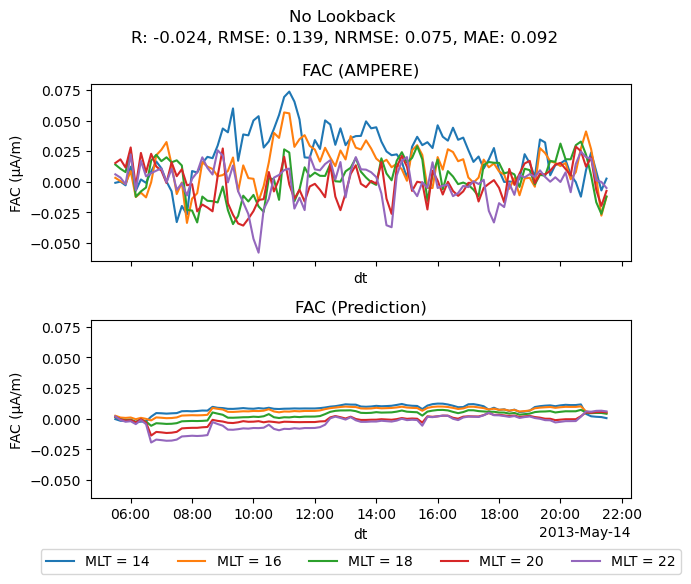

In [48]:
#linepllot of Jpat true across all mlat and mlt at a given timestep with dt as x-axis
fig, ax = plt.subplots(2,1,figsize=(7, 6), sharex=True, sharey=True)
ds = ds.sel(dt=slice('2013-05-14T05:30:00', '2013-05-14T21:30:00'))
ds['Jpar_true'].isel(mlt=14).mean(dim='mlat').plot(ax=ax[0], label='MLT = 14')
ds['Jpar_true'].isel(mlt=16).mean(dim='mlat').plot(ax=ax[0], label='MLT = 16')
ds['Jpar_true'].isel(mlt=18).mean(dim='mlat').plot(ax=ax[0], label='MLT = 18')
ds['Jpar_true'].isel(mlt=20).mean(dim='mlat').plot(ax=ax[0], label='MLT = 20')
ds['Jpar_true'].isel(mlt=22).mean(dim='mlat').plot(ax=ax[0], label='MLT = 22')
ax[0].set_title('FAC (AMPERE)')
ax[0].set_ylabel('FAC (µA/m)')

ds['Jpar_pred'].isel(mlt=14).mean(dim='mlat').plot(ax=ax[1], label='MLT = 14')
ds['Jpar_pred'].isel(mlt=16).mean(dim='mlat').plot(ax=ax[1], label='MLT = 16')
ds['Jpar_pred'].isel(mlt=18).mean(dim='mlat').plot(ax=ax[1], label='MLT = 18')
ds['Jpar_pred'].isel(mlt=20).mean(dim='mlat').plot(ax=ax[1], label='MLT = 20')
ds['Jpar_pred'].isel(mlt=22).mean(dim='mlat').plot(ax=ax[1], label='MLT = 22')
ax[1].set_title('FAC (Prediction)')
ax[1].set_ylabel('FAC (µA/m)')

fig.suptitle(f'No Lookback \nR: {R:.3f}, RMSE: {RMSE:.3f}, NRMSE: {NRMSE:.3f}, MAE: {MAE:.3f}', linespacing=1.5)    


legend = ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), shadow=False, ncol=5)
plt.tight_layout()
plt.savefig('No-Lookback-log2-2_LSTM.png', dpi=300)

<>:38: SyntaxWarning: invalid escape sequence '\p'
<>:38: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_10666/976270679.py:38: SyntaxWarning: invalid escape sequence '\p'
  plt.colorbar(c, ax=ax, label='J$_\parallel$ (FAC) [µA/m$^2$]', shrink=0.3, pad = 0.12,


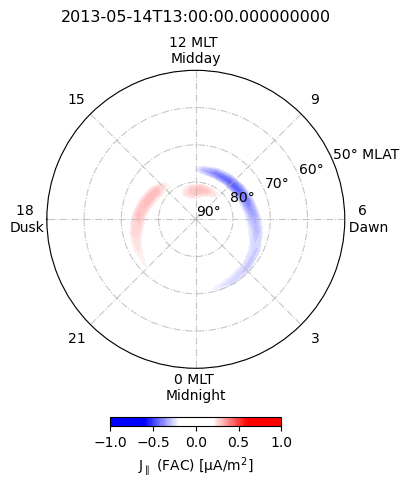

In [25]:
fac = ds['Jpar_pred'].isel(dt=timestep).values

def dt_to_str(dt):
    dt_1 = dt[0]
    dt_2 = dt[1] 
    time_1 = pd.to_datetime(dt_1)
    time_2 = pd.to_datetime(dt_2)
    str_time_1 = time_1.strftime('%Y-%m-%d %H:%M')
    str_time_2 = time_2.strftime('%Y-%m-%d %H:%M')

    return str_time_1, str_time_2

dt = ds['dt'].isel(dt=timestep).values
#start_time, end_time = dt_to_str(dt)

fac = fac.reshape(24, 50).T # reshape and transpose
fac = np.flipud(fac) # flip the array upside down
theta = np.linspace(0, 360, 24) - 90 # rotate by 90 degrees
theta = np.radians(theta) # convert to radians
r = 90 - np.linspace(40, 90, 50) #convert to colat

cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", ["blue","blue", "white", "white","red","red"])
#cmap = 'bwr'

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 5))

c = ax.contourf(theta, r, fac, cmap=cmap, levels=np.linspace(-1, 1, 100))
ax.set_ylim([0,40])
ax.set_yticks([0, 10, 20, 30,40])
ax.set_yticklabels(["90°", "80°", "70°", "60°","50° MLAT"])
ax.set_xlim([-np.pi, np.pi])
ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 MLT \nMidday", "15", "18 \nDusk"])
ax.grid(True, linestyle='-.', alpha=0.7)
ax.set_title(f"{dt}", pad=10, fontsize=11.5)


plt.colorbar(c, ax=ax, label='J$_\parallel$ (FAC) [µA/m$^2$]', shrink=0.3, pad = 0.12, 
             ticks=[-1, -0.5, 0, 0.5, 1], 
             orientation='horizontal')

plt.tight_layout()

<>:38: SyntaxWarning: invalid escape sequence '\p'
<>:38: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_10666/1210942942.py:38: SyntaxWarning: invalid escape sequence '\p'
  plt.colorbar(c, ax=ax, label='J$_\parallel$ (FAC) [µA/m$^2$]', shrink=0.3, pad = 0.12,


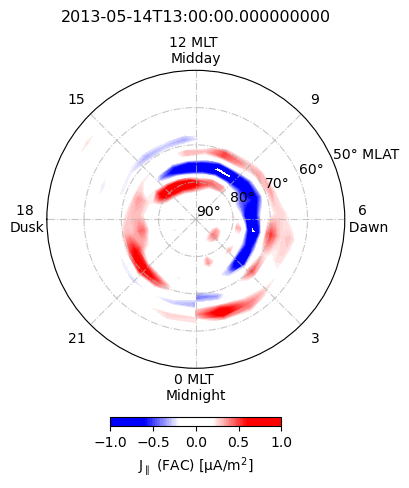

In [26]:
fac = ds['Jpar_true'].isel(dt=timestep).values

def dt_to_str(dt):
    dt_1 = dt[0]
    dt_2 = dt[1] 
    time_1 = pd.to_datetime(dt_1)
    time_2 = pd.to_datetime(dt_2)
    str_time_1 = time_1.strftime('%Y-%m-%d %H:%M')
    str_time_2 = time_2.strftime('%Y-%m-%d %H:%M')

    return str_time_1, str_time_2

dt = ds['dt'].isel(dt=timestep).values
#start_time, end_time = dt_to_str(dt)

fac = fac.reshape(24, 50).T # reshape and transpose
fac = np.flipud(fac) # flip the array upside down
theta = np.linspace(0, 360, 24) - 90 # rotate by 90 degrees
theta = np.radians(theta) # convert to radians
r = 90 - np.linspace(40, 90, 50) #convert to colat

cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", ["blue","blue", "white", "white","red","red"])
#cmap = 'bwr'

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 5))

c = ax.contourf(theta, r, fac, cmap=cmap, levels=np.linspace(-1, 1, 100))
ax.set_ylim([0,40])
ax.set_yticks([0, 10, 20, 30,40])
ax.set_yticklabels(["90°", "80°", "70°", "60°","50° MLAT"])
ax.set_xlim([-np.pi, np.pi])
ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 MLT \nMidday", "15", "18 \nDusk"])
ax.grid(True, linestyle='-.', alpha=0.7)
ax.set_title(f"{dt}", pad=10, fontsize=11.5)


plt.colorbar(c, ax=ax, label='J$_\parallel$ (FAC) [µA/m$^2$]', shrink=0.3, pad = 0.12, 
             ticks=[-1, -0.5, 0, 0.5,1], 
             orientation='horizontal')

plt.tight_layout()